In [1]:
import pandas as pd
import statistics 
import matplotlib.ticker as mticker
import scipy.stats as stats 

players = pd.read_csv("fm2023.csv")
birth_rates = pd.read_csv("Birth_Rates.csv")
birth_rates = birth_rates.drop(['Value Footnotes','Source Year','Record Type','Reliability','Area'], axis=1).dropna()

In [2]:
players.columns = players.columns.str.strip()
players['Player'] = players['Name'].str.strip()
players['Nat'] = players['Nat'].str.strip()
players['Club'] = players['Club'].str.strip()
players['Based'] = players['Based'].str.strip()

In [3]:
players_1 = players[['UID','Player','DoB', 'Nat', 'Club', 'Based',
       'Preferred Foot', 'Height','Weight']]

players_1['Height (cm)'] = players_1['Height'].str.strip().str.split(' ').str[0].astype('int')
players_1['Weight (kg)'] = players_1['Weight'].str.strip().str.split(' ').str[0].astype('int')
players_2 = players_1.drop(['Height','Weight'],axis=1)


/var/folders/08/f0gkj3cx58d1cxy80qf50nhw0000gn/T/ipykernel_25275/2519596673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_1['Height (cm)'] = players_1['Height'].str.strip().str.split(' ').str[0].astype('int')
/var/folders/08/f0gkj3cx58d1cxy80qf50nhw0000gn/T/ipykernel_25275/2519596673.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_1['Weight (kg)'] = players_1['Weight'].str.strip().str.split(' ').str[0].astype('int')


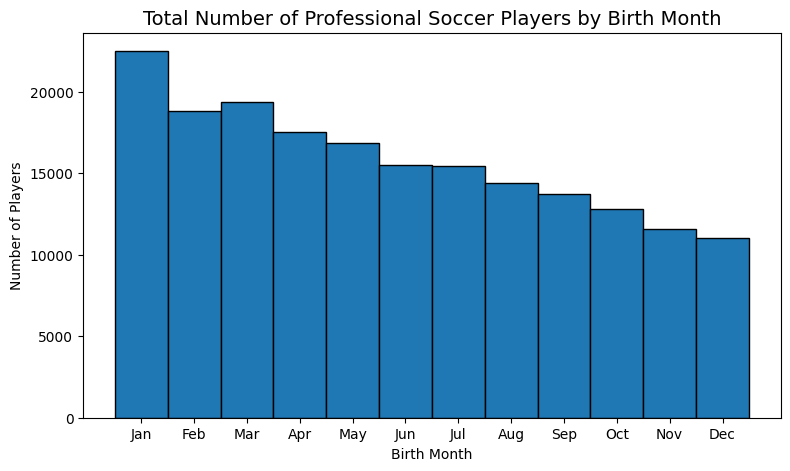

In [4]:
import calendar
import matplotlib.pyplot as plt
import numpy as np

world_mbr = pd.read_csv('World_Avg_Male_br.csv')

players_2['DoB'] = players.DoB.str.strip().str.split(' ').str[0]
players_2['DoB'] = pd.to_datetime(players_2['DoB'], format="%d/%m/%Y")
players_2['birth_month'] = players_2['DoB'].dt.month

month = players_2[['birth_month','UID']].groupby(['birth_month']).count().reset_index().rename(columns={"UID": "Count"})
month['birth_month'] = month['birth_month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(9, 5))
plt.bar(month['birth_month'], month['Count'], edgecolor = "black", width=1)

plt.ylabel("Number of Players")
plt.xlabel("Birth Month")
plt.title("Total Number of Professional Soccer Players by Birth Month",size=14);

plt.savefig('incorrect_world.png')

Since each month has a different number of days, I will standardize the values in a way that each month has 30 days. In other words, I will multiply months with 31 days by 30/31, and then February will be multiplied by 30/28.25 (factoring in leap year). 

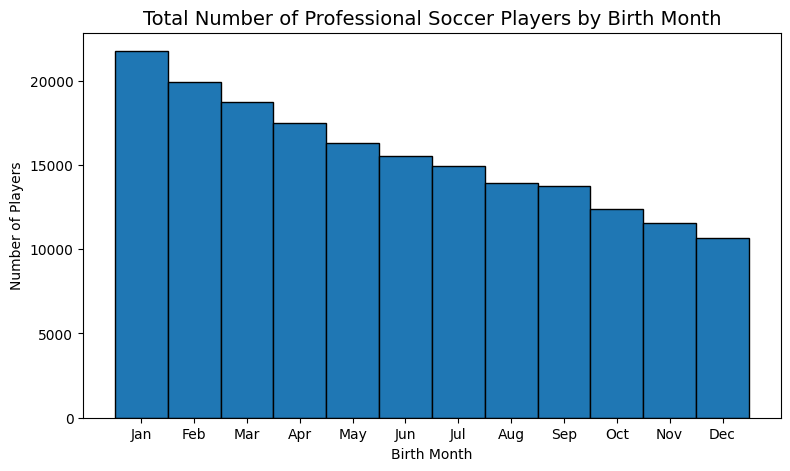

In [5]:
correction = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
c_month = month.copy()

count=0
for index, row in month.iterrows():
    c_month.loc[index, 'Count'] *= 30/correction[count]
    count +=1

c_month.Count = c_month.Count.round(2)

plt.figure(figsize=(9, 5))
plt.bar(c_month['birth_month'], c_month['Count'], width=1, edgecolor='black')

plt.ylabel("Number of Players")
plt.xlabel("Birth Month")
plt.title("Total Number of Professional Soccer Players by Birth Month",size=14);

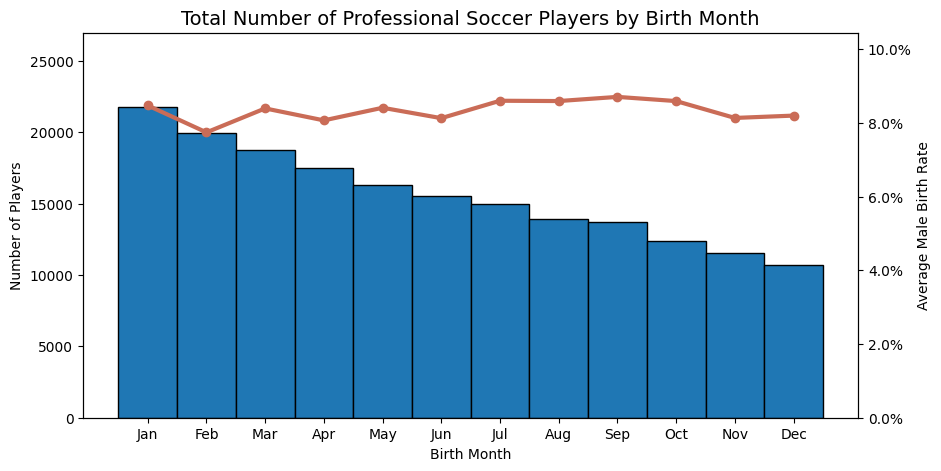

In [6]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(1,1,1)
ax1.bar(c_month['birth_month'], c_month['Count'], width=1, edgecolor='black')
ax1.set_ylim(0,month['Count'].max()*1.2)

#Add the second axes for line chart
ax2=ax1.twinx()

ax2.plot(world_mbr['birth_month'],world_mbr['Average Male Birth Rate'], '-o', color='#CA6C57',linewidth=3)
ax2.set_ylim(0,world_mbr['Average Male Birth Rate'].max()*1.2)
ticks_loc = ax2.get_yticks().tolist()
ax2.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ticks_loc])

ax1.set_ylabel("Number of Players")
ax2.set_ylabel("Average Male Birth Rate")
ax1.set_xlabel("Birth Month")
ax1.set_title("Total Number of Professional Soccer Players by Birth Month",size=14);

fig.savefig('worldwide.png')

I measured the expected count for each birth month for professional soccer players based on the average world male birth rate.

In [7]:
world_mbr['Expected Count'] = world_mbr['Average Male Birth Rate'] * c_month['Count'].sum()

count_w = world_mbr.drop(['Unnamed: 0','Average Male Birth Rate'], axis=1)
count_b = pd.merge(count_w,c_month,on=['birth_month'])

In [8]:
chi_square = pd.DataFrame(columns=['Location', 'Chi Square Test Statistic', 'P-value', "Cramer's V"],index = [0])

# birth rate of soccer players per month
# vs worldwide male birth rate per month
observed_data = count_b['Count'].tolist() 
expected_data = count_b['Expected Count'].tolist()
  
# Chi-Square Goodness of Fit Test 
chi_square_test_statistic, p_value = stats.chisquare( 
    observed_data, expected_data)

#calculate Cramer's V 
n = sum(observed_data) + sum(expected_data)
V = np.sqrt((chi_square_test_statistic/n*11))
    
#store chi square results in dataframe
chi_square.loc[0] = ['World', chi_square_test_statistic, p_value, V]
chi_square

,Location,Chi Square Test Statistic,P-value,Cramer's V
0,World,9202.768072,0.0,0.520418


Let's look closer at the professional soccer player's birth months by country...

In [9]:
Arg_mbr = pd.read_csv('Arg_Avg_Male_br.csv')
Bra_mbr = pd.read_csv('Bra_Avg_Male_br.csv')
It_mbr = pd.read_csv('Italy_Avg_Male_br.csv')
Sp_mbr = pd.read_csv('Spain_Avg_Male_br.csv')
UK_mbr = pd.read_csv('UK_Avg_Male_br.csv')
US_mbr = pd.read_csv('US_Avg_Male_br.csv')

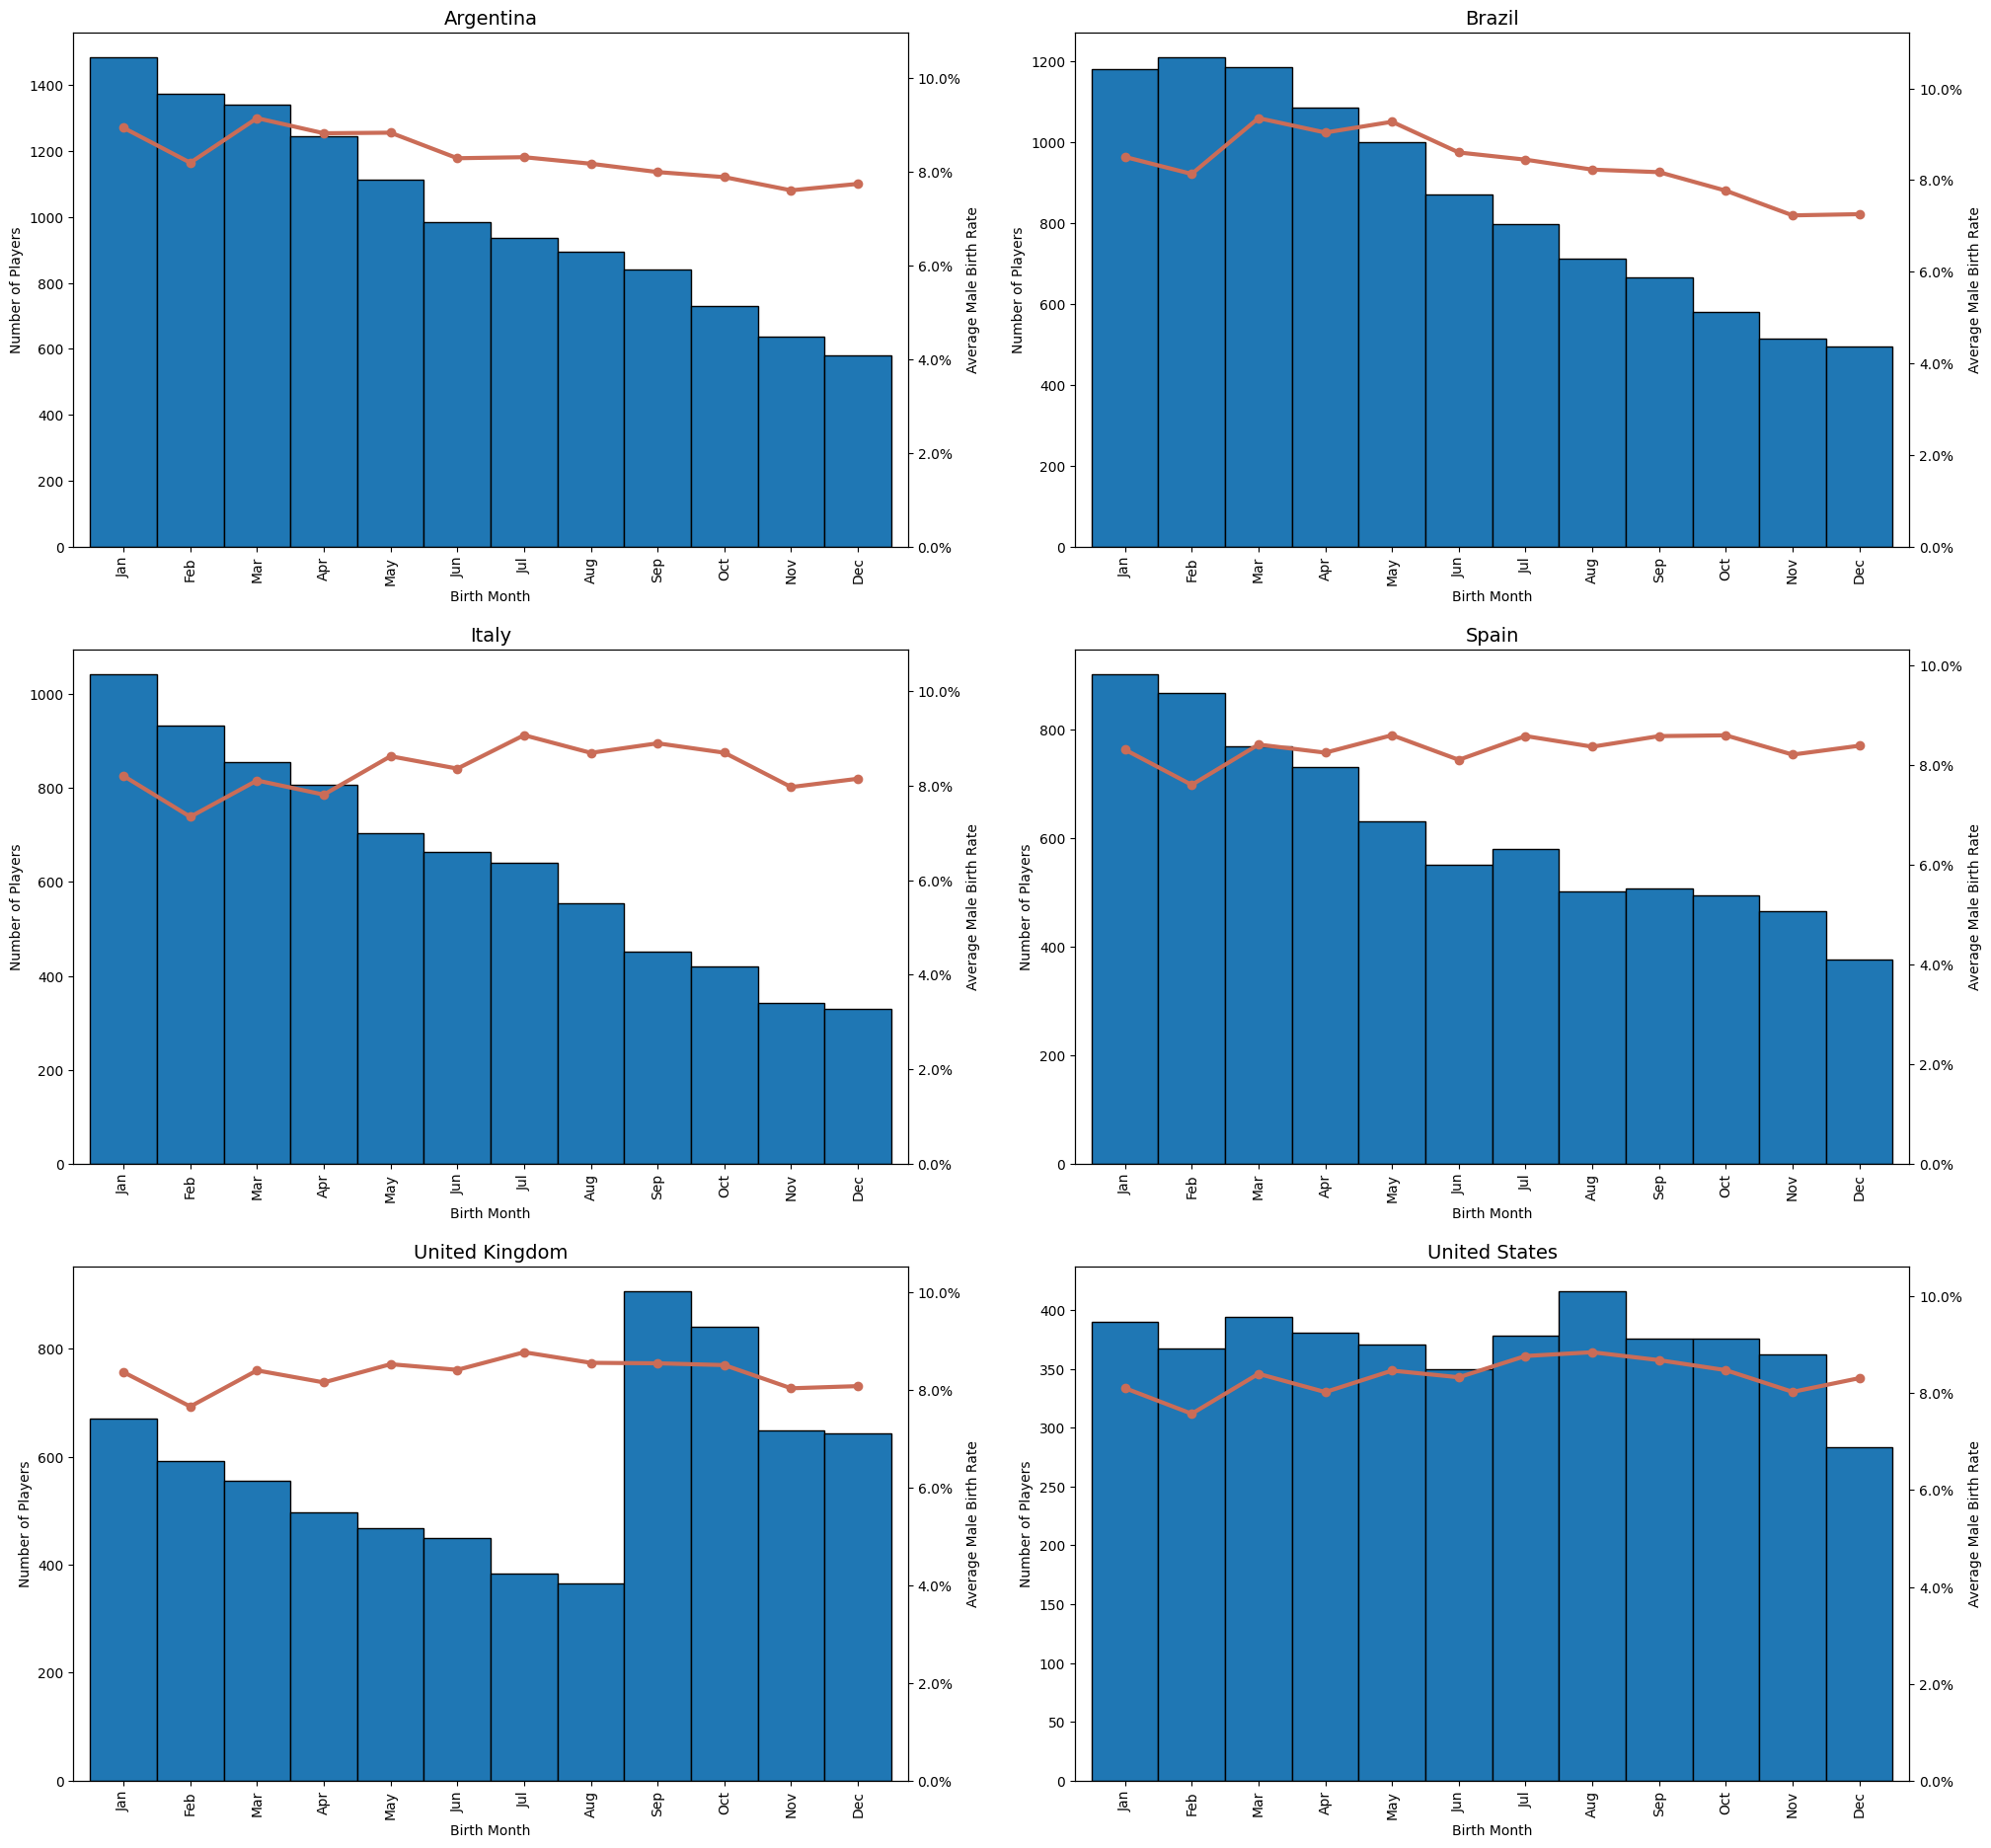

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(24, 23))

# unpack all the axes subplots
axe = axes.ravel()

countries = ['ARG', 'BRA', 'ITA', 'ESP', 'ENG', 'USA']
unabbreviated = ['Argentina', 'Brazil', 'Italy', 'Spain', 'United Kingdom', 'United States']
mbr = [Arg_mbr, Bra_mbr, It_mbr, Sp_mbr, UK_mbr, US_mbr]

#create DataFrame to store Chi Square results
chi_square = pd.DataFrame(columns=['Country', 'Chi Square Test Statistic', 'P-value', "Cramer's V"],index = [0,1,2,3,4,5])

players_2['Nat'] = players_2['Nat'].str.strip()
pvalus = []
for i in range(len(countries)):
    player_subset = players_2[players_2['Nat'] == countries[i]]
    
    country = player_subset[['birth_month','UID']].groupby(['birth_month']).count().reset_index().rename(columns={"UID": "Count"})
    country['birth_month'] = country['birth_month'].apply(lambda x: calendar.month_abbr[x])

    count=0
    for index, row in country.iterrows():
        country.loc[index, 'Count'] *= 30/correction[count]
        count +=1
        
    country.plot(kind='bar', x = 'birth_month', y = 'Count', ax=axe[i], width=1, edgecolor='black')
    axe[i].set_title(unabbreviated[i],size=14)
    axe[i].get_legend().remove()
    
    #Add the second axes for line chart
    ax2=axe[i].twinx()
    
    current_mbr = mbr[i]
    ax2.plot(current_mbr['birth_month'],current_mbr['Average Male Birth Rate'], '-o', color='#CA6C57',linewidth=3)
    ax2.set_ylim(0,current_mbr['Average Male Birth Rate'].max()*1.2)
    ticks_loc = ax2.get_yticks().tolist()
    ax2.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ticks_loc])
    
    axe[i].set_ylabel("Number of Players")
    ax2.set_ylabel("Average Male Birth Rate")
    axe[i].set_xlabel("Birth Month")
    
    current_mbr['Expected Count'] = current_mbr['Average Male Birth Rate'] * country['Count'].sum()
    
    # birth rate of Italian soccer players per month
    # vs current country's male birth rate per month
    observed_data = country['Count'].tolist() 
    expected_data = current_mbr['Expected Count'].tolist()

    # Chi-Square Goodness of Fit Test 
    chi_square_test_statistic, p_value = stats.chisquare( 
        observed_data, expected_data)

    p_value = "{:.3g}".format(p_value)
    pvalus.append(float(p_value))
    
    
    #calculate Cramer's V 
    n = sum(observed_data) + sum(expected_data)
    V = np.sqrt((chi_square_test_statistic/n*11))
        
    #store chi square results in dataframe
    chi_square.loc[i] = [unabbreviated[i], chi_square_test_statistic, p_value, V]
    
fig.savefig("countries.png")

In [11]:

country

,birth_month,Count
0,Jan,390.000000
1,Feb,367.433628
2,Mar,393.870968
3,Apr,381.000000
4,May,370.645161
5,Jun,350.000000
6,Jul,378.387097
7,Aug,416.129032
8,Sep,376.000000
9,Oct,375.483871


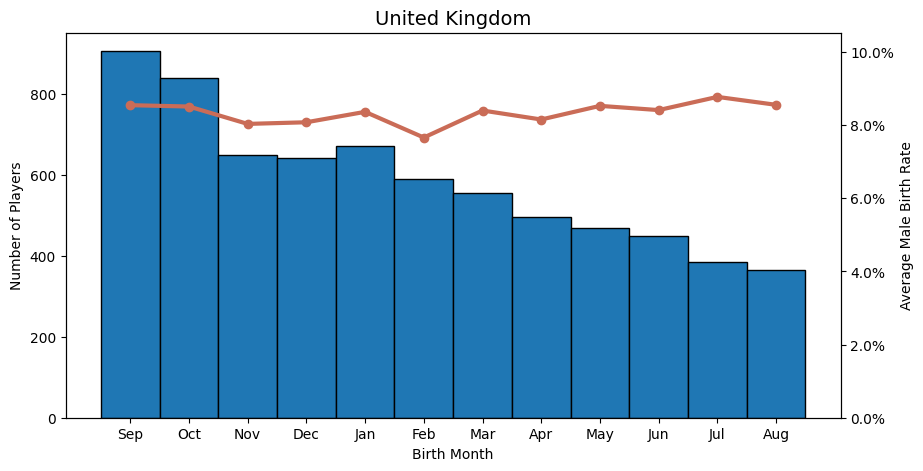

In [12]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(1,1,1)

player_subset = players_2[players_2['Nat'] == 'ENG']
    
country = player_subset[['birth_month','UID']].groupby(['birth_month']).count().reset_index().rename(columns={"UID": "Count"})
country['birth_month'] = country['birth_month'].apply(lambda x: calendar.month_abbr[x])

count=0
for index, row in country.iterrows():
    country.loc[index, 'Count'] *= 30/correction[count]
    count +=1

month_order = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", 'May', "Jun", "Jul", "Aug"]
country = country.set_index('birth_month').loc[month_order].reset_index()

ax1.bar(country['birth_month'], country['Count'], width=1, edgecolor='black')
#ax1.set_ylim(0,country['Count'].max()*1.2)

#Add the second axes for line chart
ax2=ax1.twinx()

UK_mbr = UK_mbr.set_index('birth_month').loc[month_order].reset_index()

ax2.plot(UK_mbr['birth_month'],UK_mbr['Average Male Birth Rate'], '-o', color='#CA6C57',linewidth=3)
ax2.set_ylim(0,UK_mbr['Average Male Birth Rate'].max()*1.2)
ticks_loc = ax2.get_yticks().tolist()
ax2.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ticks_loc])

ax1.set_ylabel("Number of Players")
ax2.set_ylabel("Average Male Birth Rate")
ax1.set_xlabel("Birth Month")
ax1.set_title("United Kingdom",size=14);

fig.savefig('UK.png')

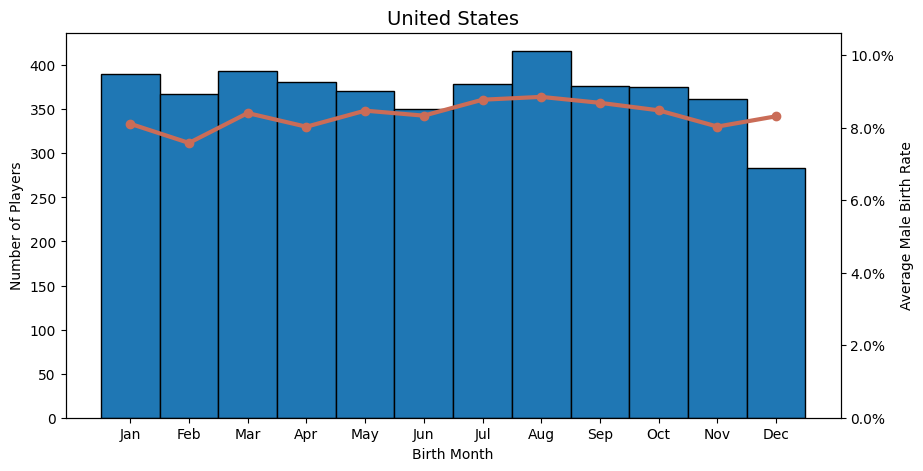

In [13]:
us_players = players_2[players_2['Nat'] == 'USA']
    
us = us_players[['birth_month','UID']].groupby(['birth_month']).count().reset_index().rename(columns={"UID": "Count"})
us['birth_month'] = us['birth_month'].apply(lambda x: calendar.month_abbr[x])

count=0
for index, row in us.iterrows():
    us.loc[index, 'Count'] *= 30/correction[count]
    count +=1

fig=plt.figure(figsize=(10,5))
ax3=plt.subplot(1,1,1)
ax3.bar(us['birth_month'], us['Count'], width=1, edgecolor='black')
#ax3.set_ylim(0,us['Count'].max()*1.2)

#Add the second axes for line chart
ax4=ax3.twinx()

ax4.plot(US_mbr['birth_month'],US_mbr['Average Male Birth Rate'], '-o', color='#CA6C57',linewidth=3)
ax4.set_ylim(0,US_mbr['Average Male Birth Rate'].max()*1.2)
ticks_loc = ax4.get_yticks().tolist()
ax4.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax4.set_yticklabels(['{:,.1%}'.format(x) for x in ticks_loc])

ax3.set_ylabel("Number of Players")
ax4.set_ylabel("Average Male Birth Rate")
ax3.set_xlabel("Birth Month")
ax3.set_title("United States",size=14);

fig.savefig('US.png')

multiple hypthosis testing
rewrite pvalues
multiply p values with a number of different tests performing (Bonferroni)

focus on how much SMALLER the other pvalues are in comparison to US pvalue rather than it being small in itself


In [14]:
chi_square

,Country,Chi Square Test Statistic,P-value,Cramer's V
0,Argentina,682.296618,3.36e-139,0.555585
1,Brazil,633.868938,7.92e-129,0.581695
2,Italy,1114.769709,3.74e-232,0.889407
3,Spain,578.697116,5.03e-117,0.656595
4,United Kingdom,550.727392,4.77e-111,0.656799
5,United States,31.196242,0.00103,0.196481


In [15]:
import statsmodels.stats.multitest as multi

In [16]:
significant, corrected_p_val, a,b = multi.multipletests(pvalus, alpha=0.05, method='bonferroni')
chi_square['Bonferroni Correction'] = corrected_p_val
chi_square

,Country,Chi Square Test Statistic,P-value,Cramer's V,Bonferroni Correction
0,Argentina,682.296618,3.36e-139,0.555585,2.016000e-138
1,Brazil,633.868938,7.92e-129,0.581695,4.752000e-128
2,Italy,1114.769709,3.74e-232,0.889407,2.244000e-231
3,Spain,578.697116,5.03e-117,0.656595,3.018000e-116
4,United Kingdom,550.727392,4.77e-111,0.656799,2.862000e-110
5,United States,31.196242,0.00103,0.196481,6.180000e-03


Switch to a mainstream physical sport (NCAA Basketball)
Do we get the same distribution?? 
If the selection hadnt been financial...

In [17]:
ncaa_bb = pd.read_csv('ncaa_bb.csv')

In [18]:
ncaa_bb

,Unnamed: 0,birth_month,Count
0,0,Jan,3092.90
1,1,Feb,2902.30
2,2,Mar,2971.94
3,3,Apr,2835.00
4,4,May,2776.45
5,5,Jun,2759.00
6,6,Jul,2806.45
7,7,Aug,2831.61
8,8,Sep,3246.00
9,9,Oct,3022.26


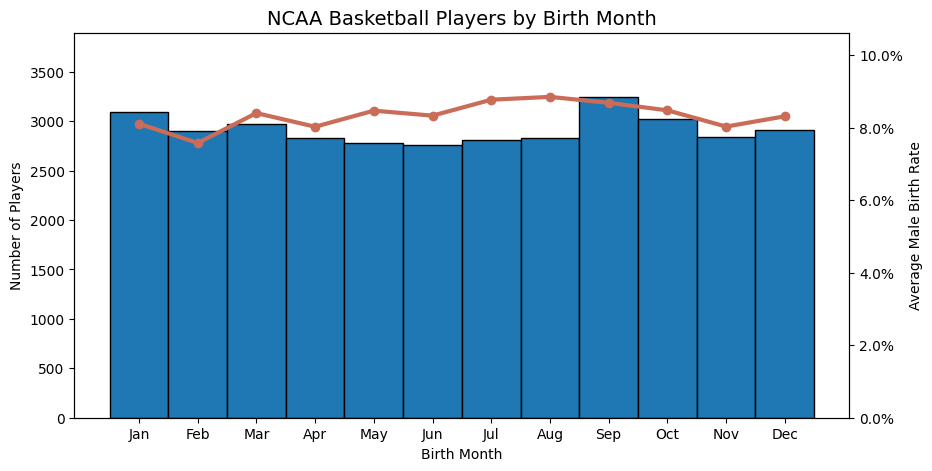

In [19]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(1,1,1)
ax1.bar(ncaa_bb['birth_month'], ncaa_bb['Count'], width=1, edgecolor='black')
ax1.set_ylim(0,ncaa_bb['Count'].max()*1.2)

#Add the second axes for line chart
ax2=ax1.twinx()

ax2.plot(US_mbr['birth_month'],US_mbr['Average Male Birth Rate'], '-o', color='#CA6C57',linewidth=3)
ax2.set_ylim(0,US_mbr['Average Male Birth Rate'].max()*1.2)
ticks_loc = ax2.get_yticks().tolist()
ax2.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ticks_loc])

ax1.set_ylabel("Number of Players")
ax2.set_ylabel("Average Male Birth Rate")
ax1.set_xlabel("Birth Month")
ax1.set_title("NCAA Basketball Players by Birth Month",size=14);

# unpack all the axes subplots
axe = axes.ravel()

#create DataFrame to store Chi Square results
chi_square_US = pd.DataFrame(columns=['Sport', 'Chi Square Test Statistic', 'P-value'],index = [0,1])

#create DataFrame to store Chi Square results
chi_square_compare = pd.DataFrame(columns=['Sport', 'Chi Square Test Statistic', 'P-value'],index = [0,1])

fig.savefig('NCAA.png')

In [20]:
us_players = players_2[players_2['Nat'] == 'USA']
    
us = player_subset[['birth_month','UID']].groupby(['birth_month']).count().reset_index().rename(columns={"UID": "Count"})
us['birth_month'] = us['birth_month'].apply(lambda x: calendar.month_abbr[x])

count=0
for index, row in us.iterrows():
    us.loc[index, 'Count'] *= 30/correction[count]
    count +=1

ncaa_bb['total'] = ncaa_bb['Count'].sum()

us['total'] = us['Count'].sum()
us['rate'] = us['Count']/us['total']
us['NCAA'] = us['rate'] * ncaa_bb['total']

#create DataFrame to store Chi Square results
chi_square_US = pd.DataFrame(columns=['Chi Square Test Statistic', 'P-value', "Cramer's V"],index = [0])

#create DataFrame to store Chi Square results
chi_square_compare = pd.DataFrame(columns=['Chi Square Test Statistic', 'P-value', "Cramer's V"],index = [0])

US_mbr['Expected Count'] = US_mbr['Average Male Birth Rate'] * ncaa_bb['Count'].sum()

# birth rate of sport's players per month
# vs world's male birth rate per month
observed_data = ncaa_bb['Count'].tolist() 
expected_data = US_mbr['Expected Count'].tolist()

# Chi-Square Goodness of Fit Test 
chi_square_test_statistic, p_value = stats.chisquare( 
    observed_data, expected_data)
p_value = "{:.3g}".format(p_value)

#calculate Cramer's V 
n = sum(observed_data) + sum(expected_data)
V = np.sqrt((chi_square_test_statistic/n*11))

#store chi square results in dataframe
chi_square_US.loc[0] = [chi_square_test_statistic, p_value, V]

chi_square_test_statistic, p_value = stats.chisquare(ncaa_bb['Count'].tolist(), us['NCAA'].tolist())
p_value = "{:.3g}".format(p_value)

#calculate Cramer's V 
n = sum(ncaa_bb['Count'].tolist()) + sum(us['NCAA'].tolist())
V = np.sqrt((chi_square_test_statistic/n*11))

#store chi square results in dataframe
chi_square_compare.loc[0] = [chi_square_test_statistic, p_value, V]

In [21]:
chi_square_US

,Chi Square Test Statistic,P-value,Cramer's V
0,128.177371,4.07e-22,0.141941


In [22]:
chi_square_compare

,Chi Square Test Statistic,P-value,Cramer's V
0,2032.637879,0,0.56524


In [23]:
plt.savefig('height.png')

<Figure size 640x480 with 0 Axes>

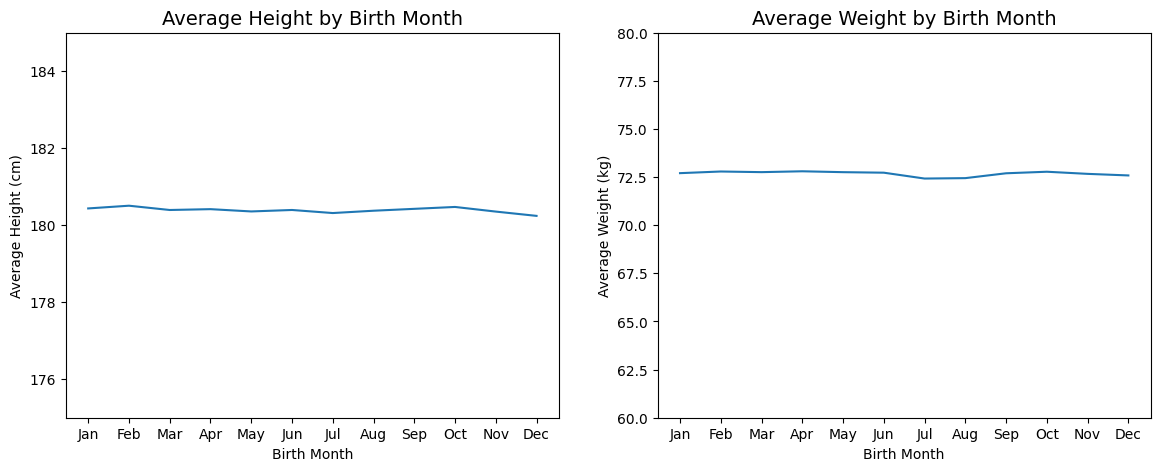

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# unpack all the axes subplots
axe = axes.ravel()

height = players_2[['birth_month','Height (cm)']].groupby(['birth_month']).mean().reset_index().rename(columns={"Height (cm)": "Average height (cm)"})
height['birth_month'] = height['birth_month'].apply(lambda x: calendar.month_abbr[x])

height.plot(x = 'birth_month', y = 'Average height (cm)', ax=axe[0])
axe[0].set_ylim(175, 185)
axe[0].set_ylabel("Average Height (cm)")
axe[0].set_xlabel("Birth Month")
axe[0].set_title("Average Height by Birth Month",size=14)
axe[0].get_legend().remove()
axe[0].set_xticks(np.arange(len(height)))
axe[0].set_xticklabels(height['birth_month']);

weight = players_2[['birth_month','Weight (kg)']].groupby(['birth_month']).mean().reset_index().rename(columns={"Weight (kg)": "Average weight (kg)"})
weight['birth_month'] = weight['birth_month'].apply(lambda x: calendar.month_abbr[x])

weight.plot(x = 'birth_month', y = 'Average weight (kg)', ax=axe[1])
axe[1].set_ylim(60, 80)
axe[1].set_ylabel("Average Weight (kg)")
axe[1].set_xlabel("Birth Month")
axe[1].set_title("Average Weight by Birth Month",size=14)
axe[1].get_legend().remove()
axe[1].set_xticks(np.arange(len(weight)))
axe[1].set_xticklabels(weight['birth_month']);

fig.savefig('h_w.png')

In [25]:
stats_2018 = pd.read_csv('2018.csv')
stats_2019 = pd.read_csv('2019.csv')
stats_2020 = pd.read_csv('2020.csv')
stats_2021 = pd.read_csv('2021.csv')
stats_2022 = pd.read_csv('2022.csv')

players_2['Born'] = players_2['DoB'].astype(str).str[:4]
players_2['Born'] = players_2['Born'].astype(int)
player_stats_2022 = pd.merge(players_2,stats_2022,on=['Player','Based','Born'])

gk_2022 = pd.read_csv('gk_2022.csv')
gk_stats_2022 = pd.merge(players_2,gk_2022,on=['Player','Based','Born'])

In [26]:
gk_stats_2022
gk_stats_2022 = gk_stats_2022.drop_duplicates('UID')
gk_stats_2022

,UID,Player,DoB,Nat,Club,Based,Preferred Foot,Height (cm),Weight (kg),birth_month,...,Err,Total Cmp%,Short Cmp%,Medium Cmp%,Long Cmp%,Ast,xAG,xA,KP,PrgP
0,964419,Nahuel Guzmán,1986-02-10,ARG,Tigres,Mexico (First Division),Right Only,192,90,2,...,1,75.4,99.5,97.4,52.8,0,0.0,0.0,1,0
1,5666492,Guillermo Ochoa,1985-07-13,MEX,América,Mexico (First Division),Right,185,78,7,...,0,74.0,100.0,98.9,53.1,0,0.0,0.0,0,0
2,5662985,Alfredo Talavera,1982-09-18,MEX,FC Juárez,Mexico (First Division),Right Only,188,82,9,...,2,75.4,100.0,97.6,57.5,0,0.0,0.0,0,0
3,14023026,Esteban Andrada,1991-01-26,ARG,Monterrey,Mexico (First Division),Right Only,194,81,1,...,3,72.7,100.0,96.8,48.5,0,0.3,0.3,3,1
4,78067540,Santiago Mele,1997-09-06,URU,Unión (SF),Argentina (Premier Division),Right,185,78,9,...,0,66.2,96.6,94.6,44.7,0,0.2,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,85144921,Jean Louchet,1996-12-03,FRA,Niort,France (Ligue 2 BKT),Right Only,192,80,12,...,1,64.4,100.0,95.3,45.8,0,0.0,0.0,0,0
602,2000018649,Rafa,2003-09-28,POR,VTSC,Portugal (Premier League),Right Only,193,84,9,...,1,65.5,100.0,100.0,40.0,1,0.0,0.0,1,0
603,48038918,Thomas Callens,1998-09-06,FRA,FC Annecy,France (Ligue 2 BKT),Left Only,182,81,9,...,0,58.6,100.0,100.0,39.2,0,0.0,0.0,0,0
604,2000116604,Noah Raveyre,2005-06-22,FRA,ASSE,France (Ligue 2 BKT),Right Only,182,72,6,...,0,37.5,0.0,100.0,28.6,0,0.0,0.0,0,0


In [27]:
#begin fixing missing/incorrect data
#drop duplicate players
player_stats_2022 = player_stats_2022.drop_duplicates('UID')

#remove players with first letter of squad and club columns not the same
dup = player_stats_2022[player_stats_2022.duplicated(['Player'], keep=False)]
dup_players = dup['Player'].tolist()
for i in dup_players:
    player_stats_2022 = player_stats_2022.loc[~((player_stats_2022['Player'] == i) & (player_stats_2022.Club.str[0]!=player_stats_2022.Squad.str[0]))]

# #drop special cases
final_players_2022 = player_stats_2022.drop_duplicates( 
  subset = ['Player','Born','Squad','Club'], 
  keep = 'last').reset_index(drop = True) 

# #final player stat dataset with correct unique player data
final_players_2022

,UID,Player,DoB,Nat,Club,Based,Preferred Foot,Height (cm),Weight (kg),birth_month,...,Blocks Pass,Int,Clr,Total Cmp%,Short Cmp%,Medium Cmp%,Long Cmp%,Ast,KP,PrgP
0,831079,Giorgio Chiellini,1984-08-14,ITA,LAFC,U.S.A. (MLS),Left Only,187,85,8,...,1,14,38,82.6,91.2,88.5,59.0,1,2,51
1,2105510,Hulk,1986-07-25,BRA,ATM,Brazil (First Division),Left,179,95,7,...,4,3,12,68.6,77.2,70.4,48.4,2,40,67
2,962988,Gonzalo Higuaín,1987-12-10,ARG,Inter Miami,U.S.A. (MLS),Right,184,89,12,...,4,0,10,71.5,82.4,79.4,54.1,3,34,44
3,8825061,Fernandinho,1985-05-04,BRA,ATP,Brazil (First Division),Right,179,67,5,...,9,11,8,81.1,84.8,86.3,71.4,2,21,108
4,5132312,Gareth Bale,1989-07-16,WAL,LAFC,U.S.A. (MLS),Left,185,82,7,...,0,2,6,79.3,87.2,81.0,70.6,0,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,2000131318,Pablo Marín,2003-07-03,ESP,Real San Sebastián,Spain (First Division),Right,186,76,7,...,1,4,2,76.2,84.8,75.0,75.0,0,6,15
7398,67287574,Raúl Parra,1999-11-26,ESP,Mirandés,Spain (Second Division),Either,187,78,11,...,7,15,19,64.4,78.5,72.4,44.6,0,9,53
7399,2000165970,Pau Sans,2004-11-24,ESP,Zaragoza,Spain (Second Division),Right,183,69,11,...,2,0,1,52.4,66.7,33.3,0.0,0,1,1
7400,2000209777,Pablo Muñoz,2003-09-04,ESP,Vallecano,Spain (First Division),Right,170,60,9,...,0,0,0,100.0,100.0,0.0,0.0,0,0,1


In [28]:
phys_stats = final_players_2022[['UID', 'Player', 'DoB', 'Nat', 'Preferred Foot',
       'Height (cm)', 'Weight (kg)', 'birth_month', 'Born', 'Club']]
player_stats_2021 = pd.merge(phys_stats,stats_2021,on=['Player','Born'])
dups = player_stats_2021[player_stats_2021.duplicated(['UID'], keep=False)]
dups[['Player','90s']]

,Player,90s
18,Abel Hernández,8.6
19,Abel Hernández,6.5
24,Jonathan dos Santos,20.1
25,Jonathan dos Santos,2.3
35,Martín Cáceres,7.4
...,...,...
6111,Bilal Brahimi,32.7
6113,Jonathan Varane,0.0
6114,Jonathan Varane,1.2
6116,Iron Gomis,8.8


In [29]:
#drop duplicate players
player_stats_2021 = player_stats_2021.drop_duplicates('UID')

#remove players with first letter of squad and club columns not the same
dup = player_stats_2021[player_stats_2021.duplicated(['Player'], keep=False)]
dup_players = dup['Player'].tolist()
for i in dup_players:
    final_players_2021 = player_stats_2021.loc[~((player_stats_2021['Player'] == i) & (player_stats_2021.Club.str[0]!=player_stats_2021.Squad.str[0]))]

final_players_2021

,UID,Player,DoB,Nat,Preferred Foot,Height (cm),Weight (kg),birth_month,Born,Club,...,Blocks Pass,Int,Clr,Total Cmp%,Short Cmp%,Medium Cmp%,Long Cmp%,Ast,KP,PrgP
0,831079,Giorgio Chiellini,1984-08-14,ITA,Left Only,187,85,8,1984,LAFC,...,6,22,59,82.5,90.9,88.3,61.0,0,7,74
1,2105510,Hulk,1986-07-25,BRA,Left,179,95,7,1986,ATM,...,14,4,20,73.8,78.7,78.7,63.1,7,56,99
2,962988,Gonzalo Higuaín,1987-12-10,ARG,Right,184,89,12,1987,Inter Miami,...,11,4,16,73.6,79.5,78.5,66.2,7,36,75
3,8825061,Fernandinho,1985-05-04,BRA,Right,179,67,5,1985,ATP,...,6,8,13,88.6,93.5,90.6,70.9,1,10,81
4,5132312,Gareth Bale,1989-07-16,WAL,Left,185,82,7,1989,LAFC,...,2,2,1,69.2,80.6,76.2,60.0,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198,2000182819,Leny Yoro,2005-11-13,FRA,Right,190,76,11,2005,LOSC,...,1,0,0,100.0,100.0,100.0,0.0,0,0,2
6199,2000096635,Yoan Koré,2004-11-16,FRA,Left Only,187,78,11,2004,Paris FC,...,6,7,6,71.4,83.5,68.1,45.0,0,4,9
6200,67293613,Sergio Santos,2001-01-03,ESP,Right,180,73,1,2001,Mirandés,...,0,0,0,100.0,100.0,100.0,100.0,0,1,0
6201,2000131318,Pablo Marín,2003-07-03,ESP,Right,186,76,7,2003,Real San Sebastián,...,0,0,0,100.0,100.0,0.0,0.0,0,0,0


In [30]:
test = final_players_2022[final_players_2022['UID'].isin(final_players_2021['UID'])]
test

,UID,Player,DoB,Nat,Club,Based,Preferred Foot,Height (cm),Weight (kg),birth_month,...,Blocks Pass,Int,Clr,Total Cmp%,Short Cmp%,Medium Cmp%,Long Cmp%,Ast,KP,PrgP
0,831079,Giorgio Chiellini,1984-08-14,ITA,LAFC,U.S.A. (MLS),Left Only,187,85,8,...,1,14,38,82.6,91.2,88.5,59.0,1,2,51
1,2105510,Hulk,1986-07-25,BRA,ATM,Brazil (First Division),Left,179,95,7,...,4,3,12,68.6,77.2,70.4,48.4,2,40,67
2,962988,Gonzalo Higuaín,1987-12-10,ARG,Inter Miami,U.S.A. (MLS),Right,184,89,12,...,4,0,10,71.5,82.4,79.4,54.1,3,34,44
3,8825061,Fernandinho,1985-05-04,BRA,ATP,Brazil (First Division),Right,179,67,5,...,9,11,8,81.1,84.8,86.3,71.4,2,21,108
4,5132312,Gareth Bale,1989-07-16,WAL,LAFC,U.S.A. (MLS),Left,185,82,7,...,0,2,6,79.3,87.2,81.0,70.6,0,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7366,2000182819,Leny Yoro,2005-11-13,FRA,LOSC,France (Ligue 1 Uber Eats),Right,190,76,11,...,5,18,27,91.0,95.2,94.4,69.6,0,1,15
7372,2000096635,Yoan Koré,2004-11-16,FRA,Paris FC,France (Ligue 2 BKT),Left Only,187,78,11,...,7,11,12,80.7,90.1,78.8,55.2,0,2,27
7374,67293613,Sergio Santos,2001-01-03,ESP,Mirandés,Spain (Second Division),Right,180,73,1,...,1,2,5,71.1,86.1,67.6,50.0,0,2,3
7397,2000131318,Pablo Marín,2003-07-03,ESP,Real San Sebastián,Spain (First Division),Right,186,76,7,...,1,4,2,76.2,84.8,75.0,75.0,0,6,15


In [31]:
final_players_2022

mid_2022 = final_players_2022[(final_players_2022['Position']=='Midfielder') & (final_players_2022['90s']>=8.0)]
def_2022 = final_players_2022[(final_players_2022['Position']=='Defender') & (final_players_2022['90s']>=8.0)]
att_2022 = final_players_2022[(final_players_2022['Position']=='Forward') & (final_players_2022['90s']>=8.0)]
gk_2022 = gk_stats_2022[gk_stats_2022['90s']>=8.0]
gk_2022[gk_2022['Player']=='Bernd Leno']

,UID,Player,DoB,Nat,Club,Based,Preferred Foot,Height (cm),Weight (kg),birth_month,...,Err,Total Cmp%,Short Cmp%,Medium Cmp%,Long Cmp%,Ast,xAG,xA,KP,PrgP
365,92012109,Bernd Leno,1992-03-04,GER,Fulham,England (Premier Division),Right,190,83,3,...,0,79.5,99.6,99.4,44.3,0,0.0,0.0,1,0


final_players.corr()

height weight, birth month, nationality, preferred foot, club/squad

run, look at feature importance and determine which features impact the KPI the most

look into using more than one year of data to predict future kpi based on previous 2 seasons of in-game stats data
will help determine which are important features of KPI

using shap values will tell you why you have made certain predictions based on the features
explains reasons for clusters (ex: this cluster has a high save percentage becasue last year they had high save percentage, or this cluster had lower save percentage last year but were on a bad team that had a lot of shots on them)

1. Create success functions based on in-game statistics for each of the 4 position groups
2. 


1. Extract data from 2019, 2020 to perform model validation (if time)  
2. Separate into 4 datasets for each position
3. convert all statistics to rate (G/90, A/90, Medium Passes/90, etc.)
3. choose kpi for each group (Goals/90 for attacker, Key Passes/90 for midfielders, etc.)
4. Create algorithm to predict KPI for 2023 for each group
    a. predictions should be in form of a range (3-5 shots on target per game, 5-10 tackles per game, etc.)
5. Perform feature importance to determine which features impact the KPI prediction the most
6. Check if birth month can be attributed to predicted KPI

In [32]:
mid_2022.to_csv('2022_midfielders.csv')
def_2022.to_csv('2022_defenders.csv')
att_2022.to_csv('2022_forwards.csv')
gk_2022.to_csv('2022_goalkeepers.csv')